## Train ECG localization network

In [1]:
# Author: Ben Dai
# Licensed under the Apache License, Version 2.0 (the "License");
# Train ECG localization network

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout,MaxPooling1D,GlobalAveragePooling1D
from tensorflow.keras import Model, layers,Sequential,regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

2022-10-14 21:52:36.322750: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
## Load data and pretrained model

discriminator=tf.keras.models.load_model('./tests/ECG_model/pretrained_model.h5')
# discriminator.summary()

mit_train_path="./dataset/mitbih_train.csv"
mit_test_path="./dataset/mitbih_test.csv"

def create_pd(train_path,test_path):
    train=pd.read_csv(train_path)
    test=pd.read_csv(test_path)
    train.columns=[x for x in range(188)]
    test.columns=[x for x in range(188)]
    return pd.concat([train,test], axis=0, join='inner').sort_index()

mit= create_pd(mit_train_path,mit_test_path)

X = np.asarray(mit.iloc[:,:187].values)
y = mit.iloc[:,187].values
y = to_categorical(y)

X = X.reshape(-1, 187, 1)
input_shape = X.shape[1:]

from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

2022-10-14 21:52:39.025442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 21:52:39.030579: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 21:52:39.030931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-14 21:52:39.031751: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [3]:
## Model
from dnn_locate import loc_model
## define the backend localizer before TRELU activation

localizer_backend = tf.keras.Sequential(
    [
        layers.Input(shape=(input_shape[0], input_shape[1])),
        layers.Conv1D(
            filters=32, kernel_size=5, padding="same", strides=1, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=5, padding="same", strides=1, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=5, padding="same", strides=1, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=5, padding="same", strides=1, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=5, padding="same"),
    ]
)

es_detect1 = ReduceLROnPlateau(monitor="loss", factor=0.382, min_lr=1e-6,
                    verbose=1, patience=3, mode="min")
es_detect2 = EarlyStopping(monitor='loss', mode='min', min_delta=.0001, 
                        verbose=1, patience=10, restore_best_weights=True)


fit_params={'callbacks': [es_detect1, es_detect2],
            'epochs': 100, 'batch_size': 64}

tau_range = [10., 20, 30]

## define framework
cue = loc_model(input_shape=input_shape,
                localizer_backend=localizer_backend,
                discriminator=discriminator,
                target_r_square='auto',
                r_metric='acc',
                # r_metric='loss',
                tau_range=tau_range)

/home/ben/tf/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [4]:
cue.fit(X_train=X, y_train=y, 
            fit_params=fit_params,
            optimizer=Adam(learning_rate=.01)
            # optimizer=SGDW(learning_rate=.1, weight_decay=.0001, momentum=.9)
            )

2022-10-14 21:52:44.663196: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


2292/2292 [==============================] - 3s 1ms/step - loss: 5.1039 - accuracy: 0.7042 - auc: 0.8160
Epoch 1/100
1146/1146 [==============================] - 7s 5ms/step - loss: -5.3217 - lr: 0.0100
Epoch 2/100
1146/1146 [==============================] - 4s 4ms/step - loss: -7.3224 - lr: 0.0100
Epoch 3/100
1146/1146 [==============================] - 4s 4ms/step - loss: -7.9352 - lr: 0.0100
Epoch 4/100
1146/1146 [==============================] - 4s 4ms/step - loss: -8.1900 - lr: 0.0100
Epoch 5/100
1146/1146 [==============================] - 4s 4ms/step - loss: -8.1250 - lr: 0.0100
Epoch 6/100
1146/1146 [==============================] - 4s 4ms/step - loss: -8.2364 - lr: 0.0100
Epoch 7/100
1146/1146 [==============================] - 4s 4ms/step - loss: -8.4304 - lr: 0.0100
Epoch 8/100
1146/1146 [==============================] - 4s 4ms/step - loss: -8.7386 - lr: 0.0100
Epoch 9/100
1146/1146 [==============================] - 5s 4ms/step - loss: -8.6743 - lr: 0.0100
Epoch 10/100


1146/1146 [==============================] - ETA: 0s - loss: -10.5464
Epoch 71: ReduceLROnPlateau reducing learning rate to 1.1869803725858219e-05.
1146/1146 [==============================] - 4s 4ms/step - loss: -10.5464 - lr: 3.1073e-05
Epoch 72/100
1146/1146 [==============================] - 4s 4ms/step - loss: -10.6003 - lr: 1.1870e-05
Epoch 73/100
1146/1146 [==============================] - 4s 4ms/step - loss: -10.5594 - lr: 1.1870e-05
Epoch 74/100
1133/1146 [============================>.] - ETA: 0s - loss: -10.5983
Epoch 74: ReduceLROnPlateau reducing learning rate to 4.534264948233613e-06.
1146/1146 [==============================] - 4s 4ms/step - loss: -10.6071 - lr: 1.1870e-05
Epoch 75/100
1146/1146 [==============================] - 4s 4ms/step - loss: -10.5452 - lr: 4.5343e-06
Epoch 76/100
1146/1146 [==============================] - 4s 4ms/step - loss: -10.5684 - lr: 4.5343e-06
Epoch 77/100
1143/1146 [============================>.] - ETA: 0s - loss: -10.5494
Epoch 77: R

In [5]:
## print R_square for Test set
cue.R_square(X_test, y_test)

##################################################
compute the R2 for the fitted localizer.
##################################################
1129/1129 [==============================] - 2s 1ms/step - loss: 11.0295 - accuracy: 0.1713 - auc: 0.4927


0.9833611752340135

1/1 [==============================] - 0s 12ms/step


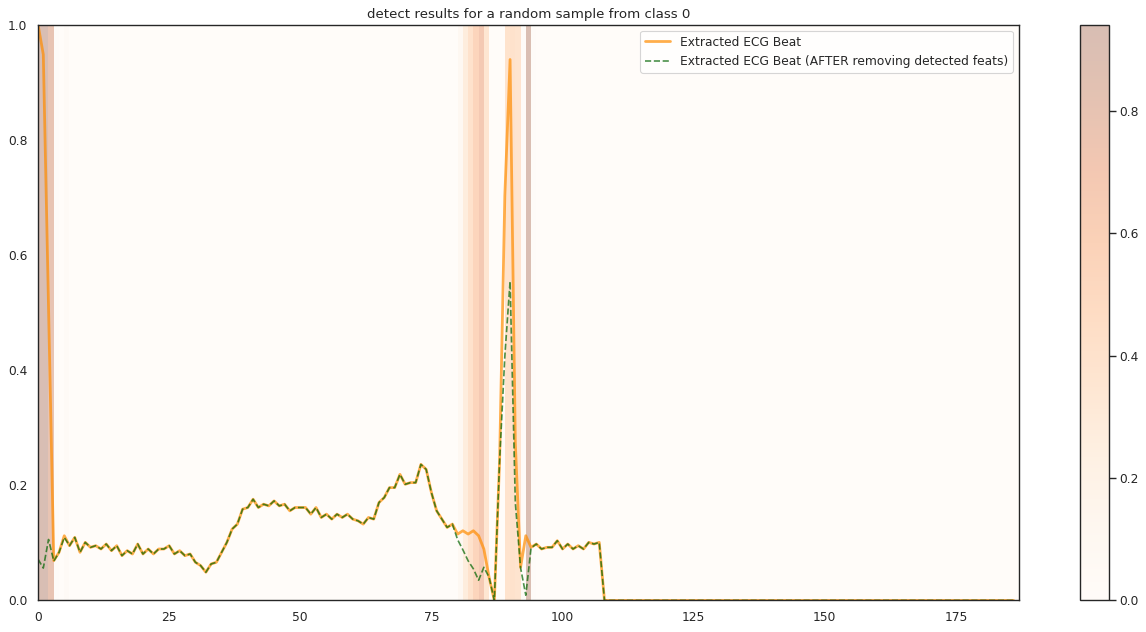

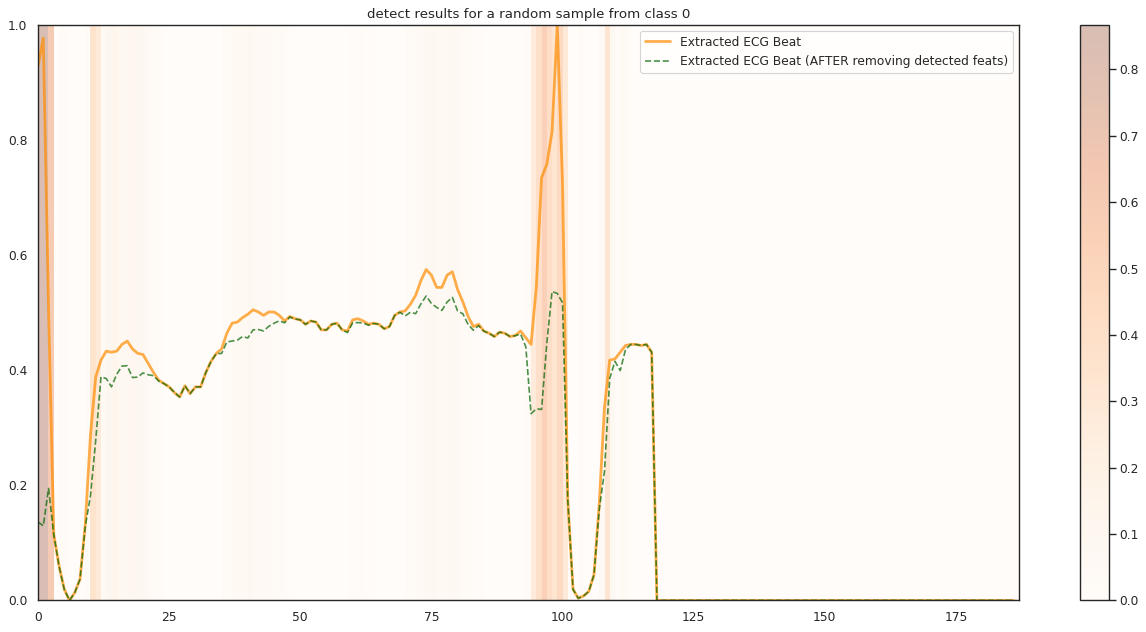

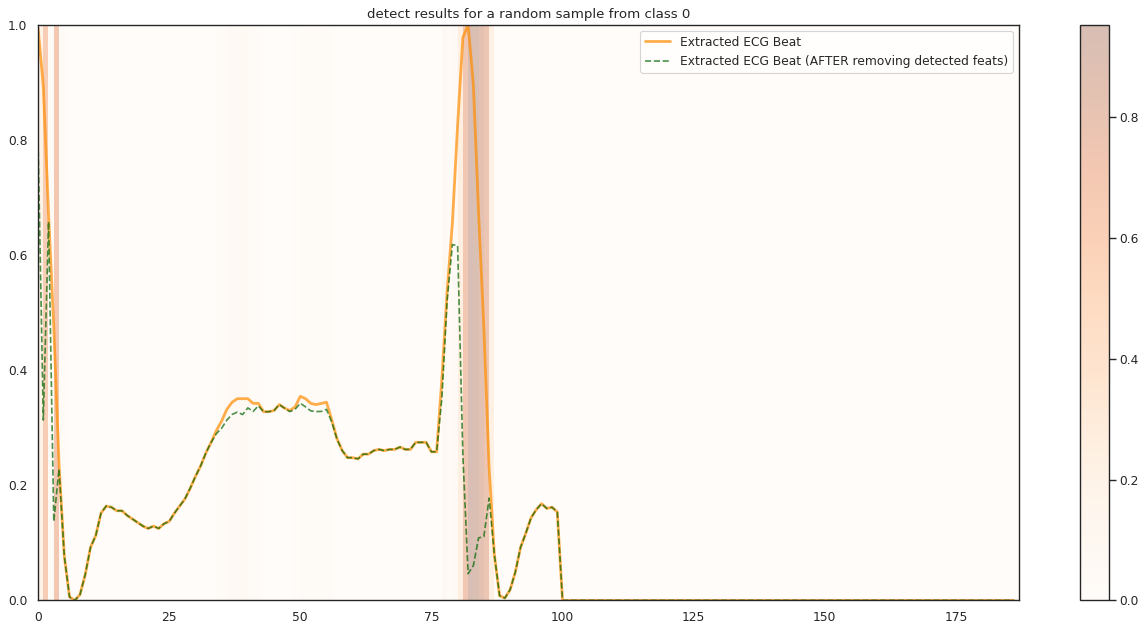

1/1 [==============================] - 0s 12ms/step


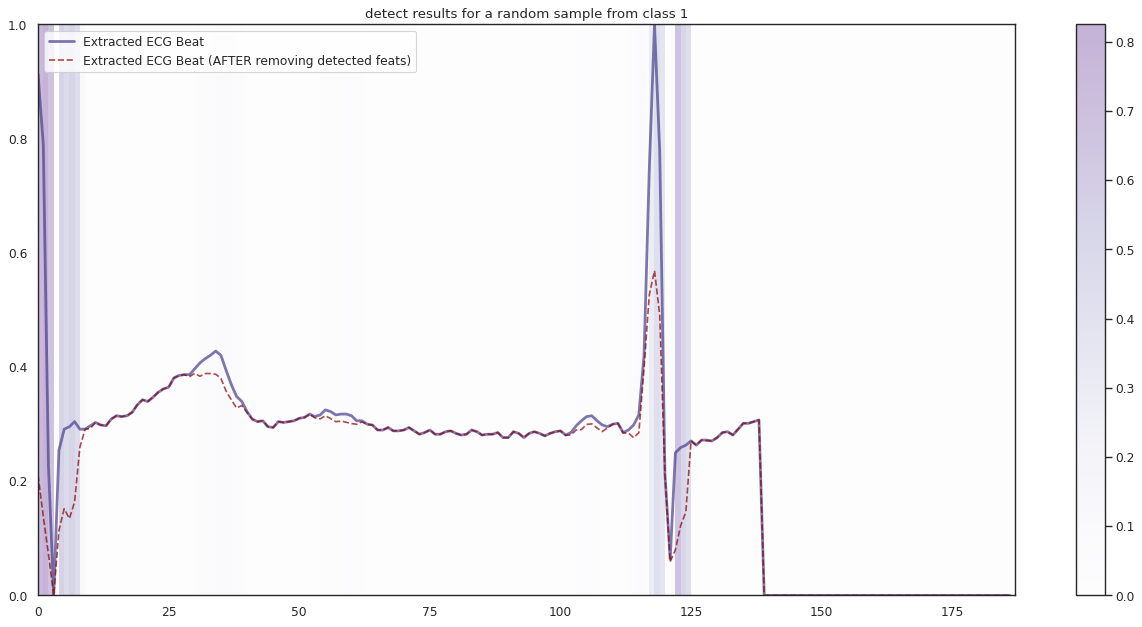

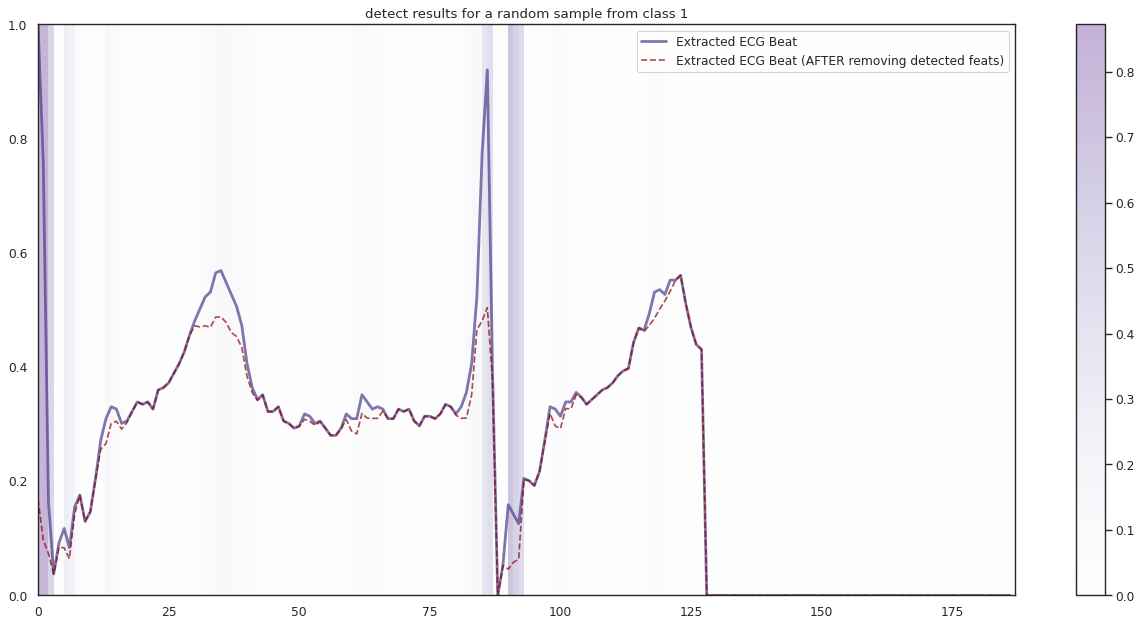

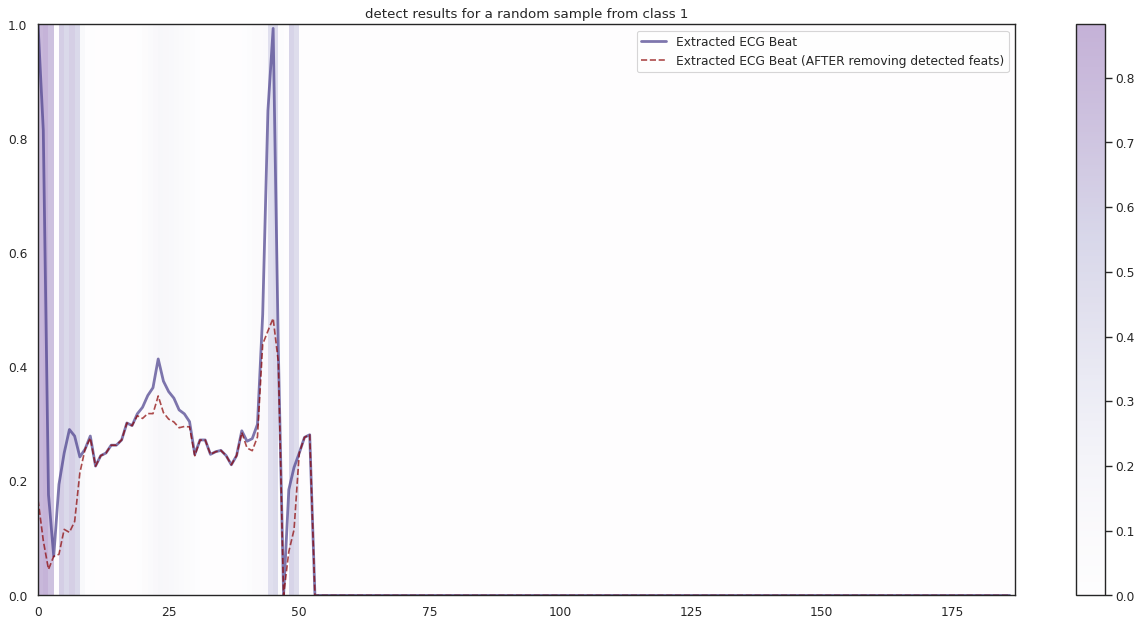

1/1 [==============================] - 0s 12ms/step


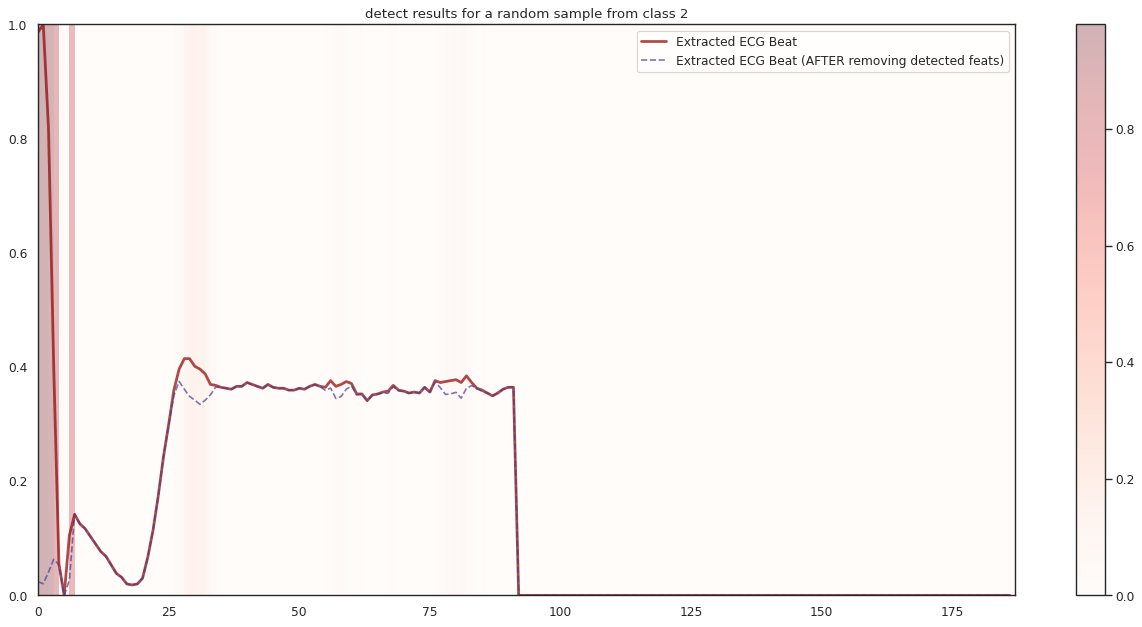

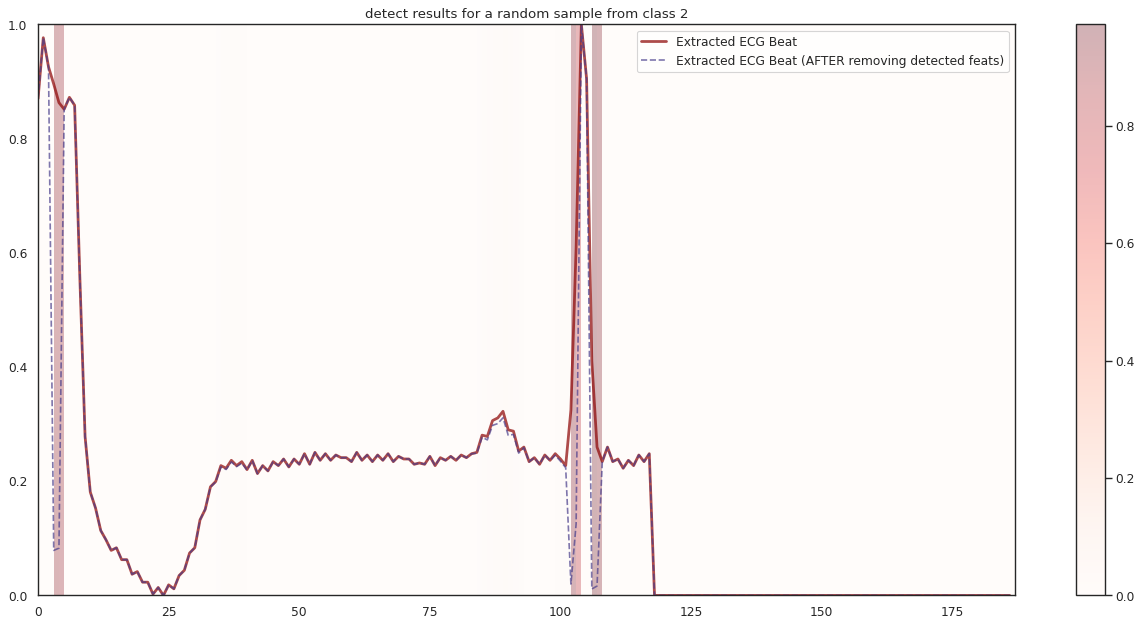

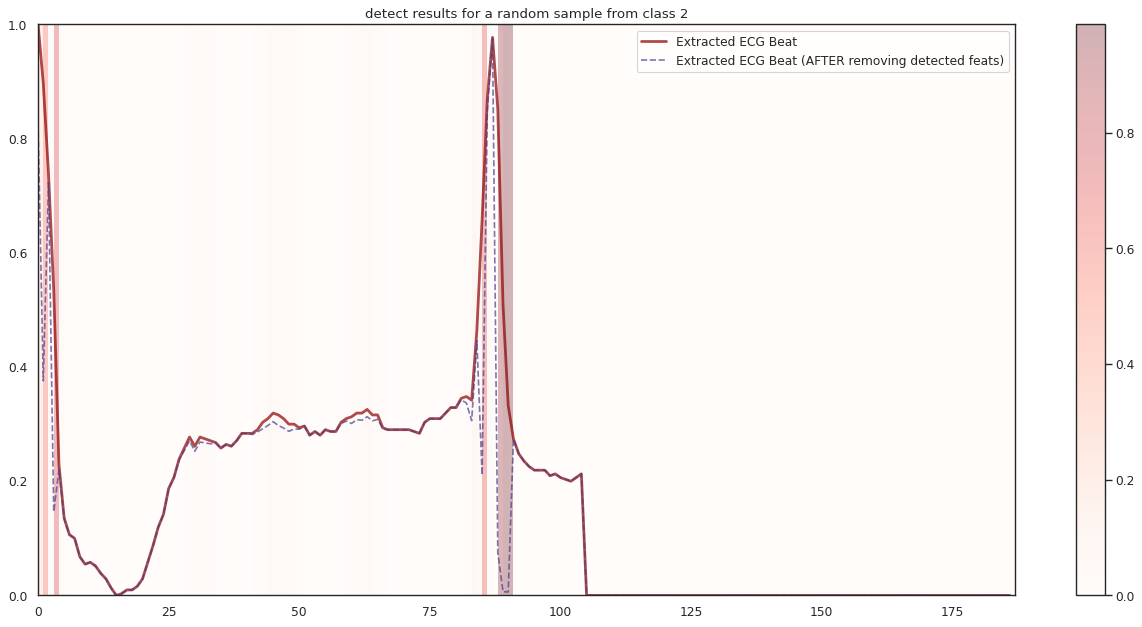

1/1 [==============================] - 0s 12ms/step


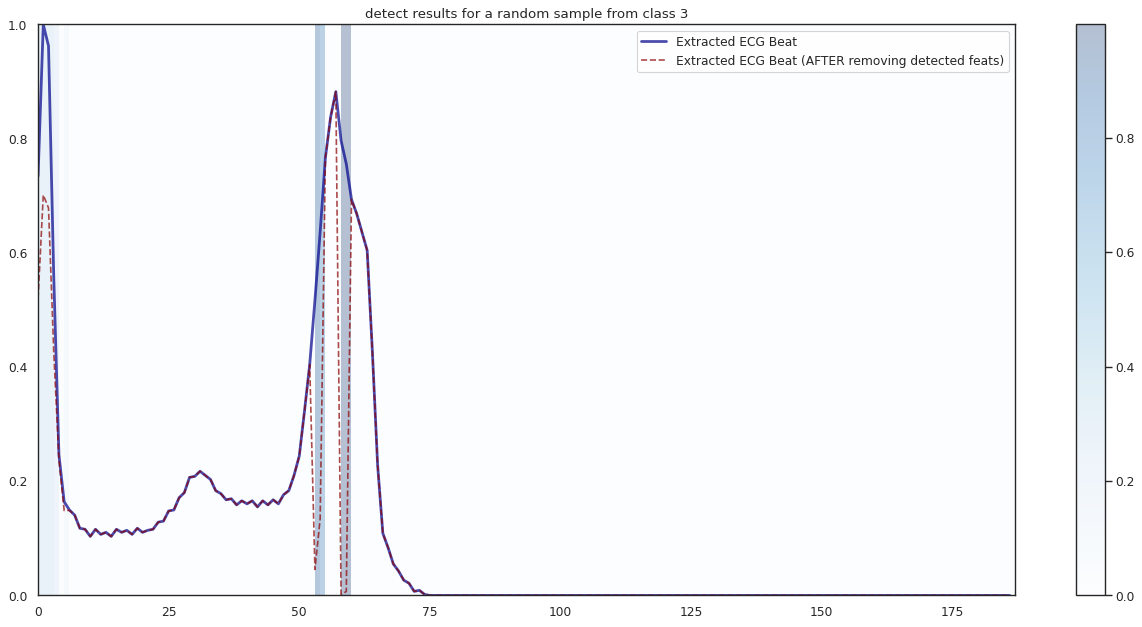

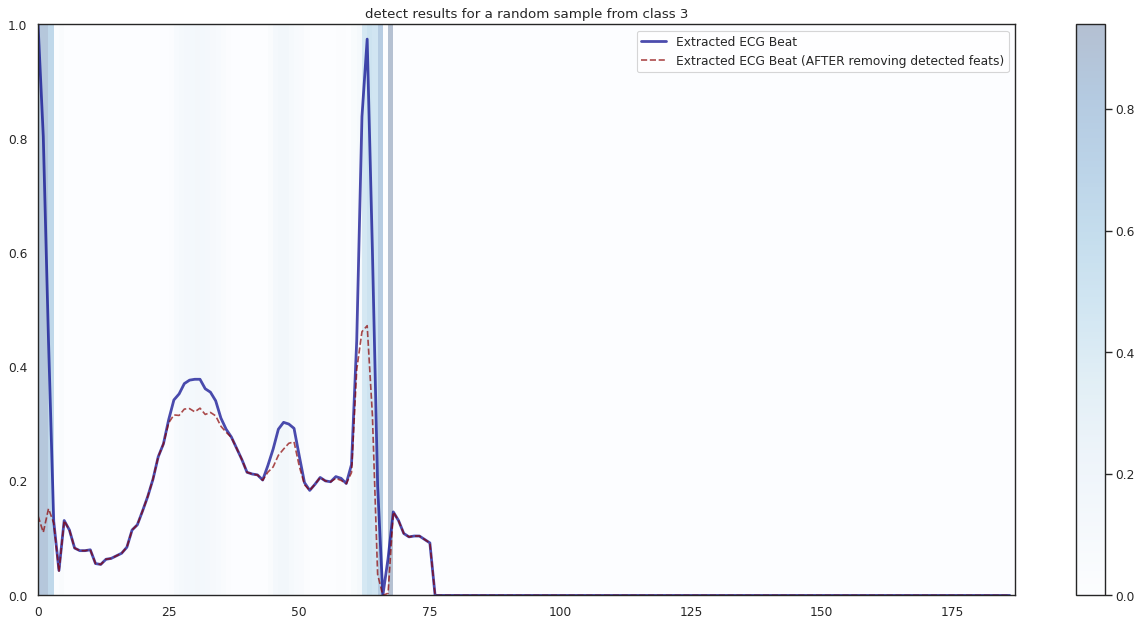

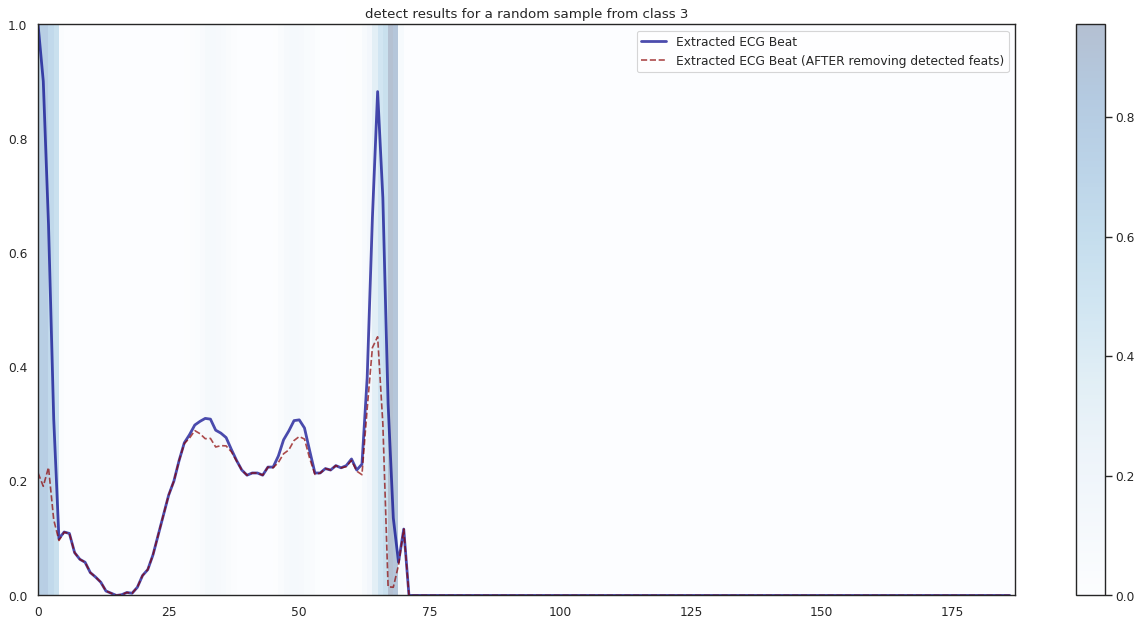

1/1 [==============================] - 0s 12ms/step


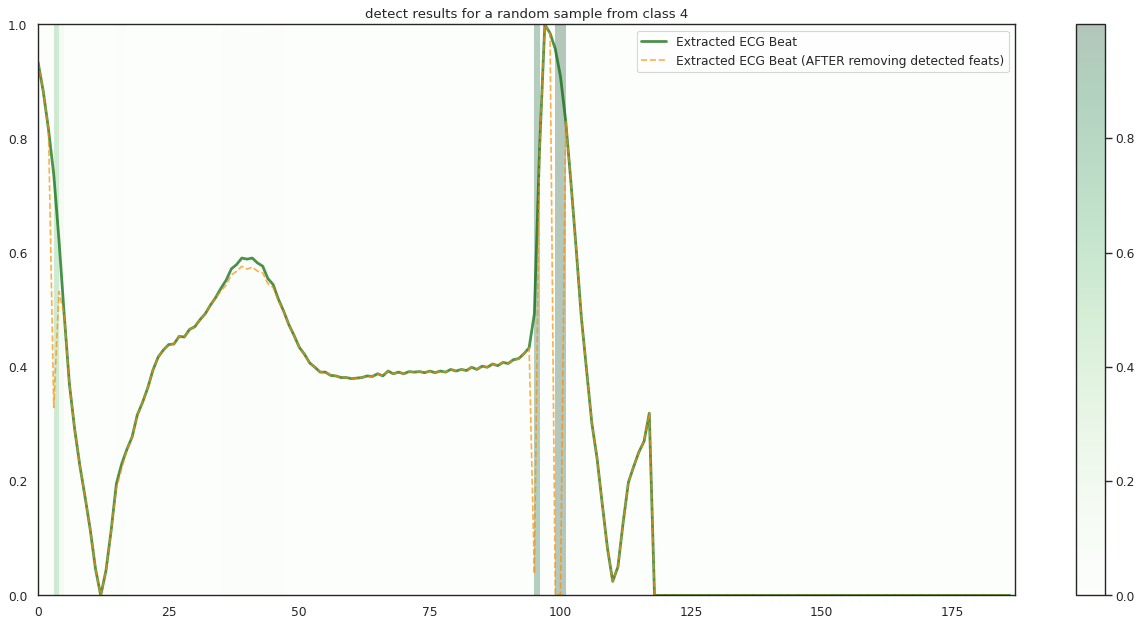

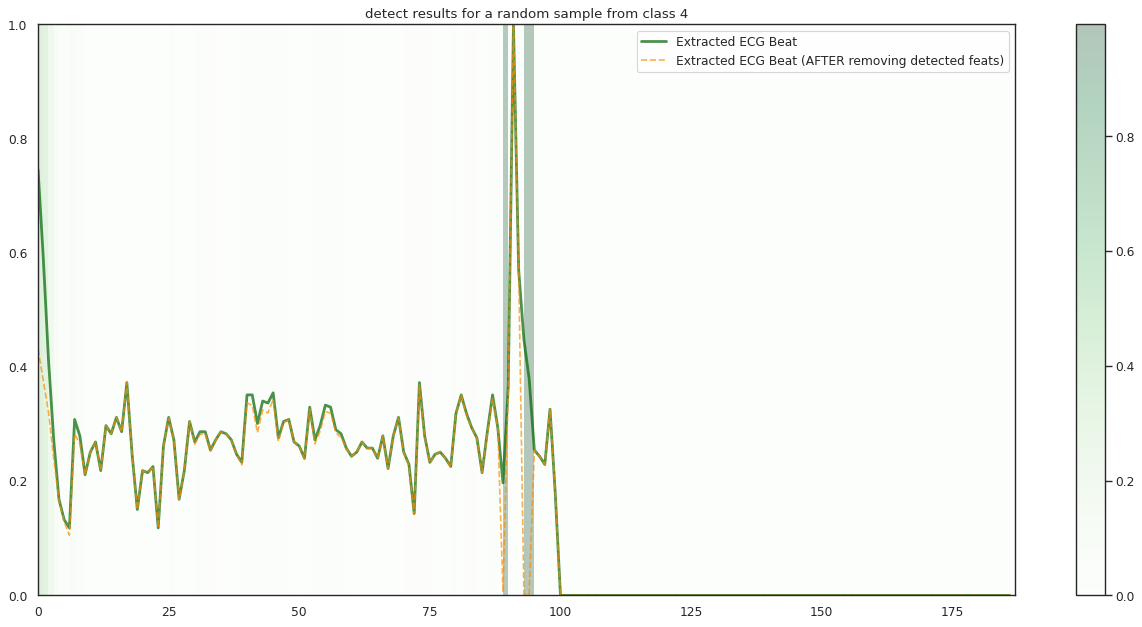

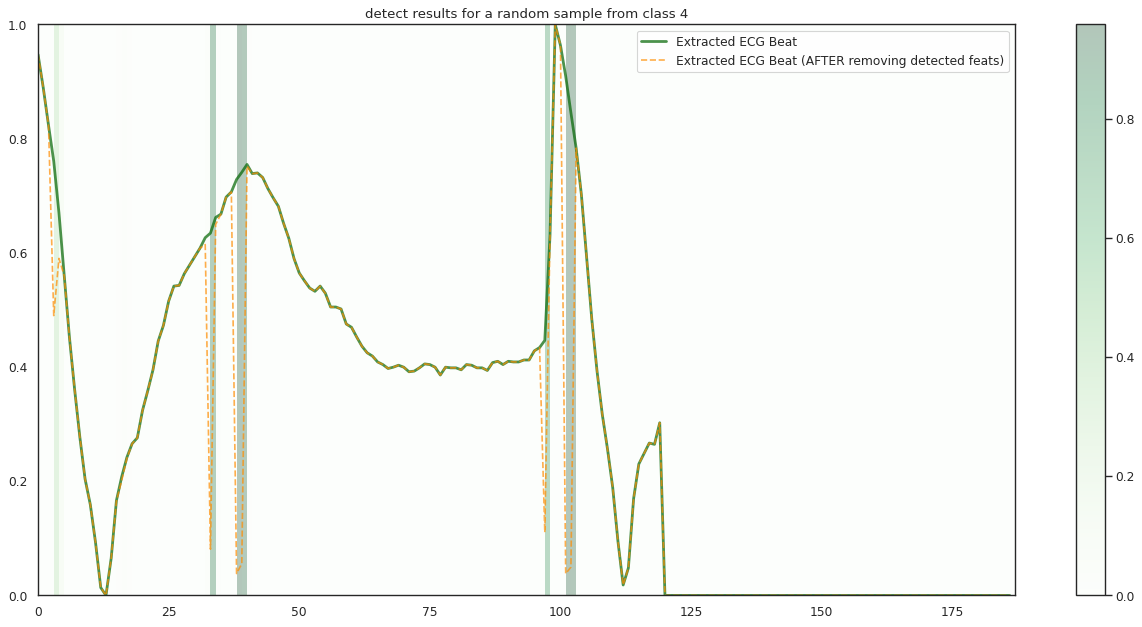

In [6]:
## Plot the localization results by the fitted network for novel instances
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt

n_label = y.shape[1]
cmap = ["Oranges", "Purples", "Reds", "Blues", "Greens"]
c1 = ['darkorange', 'darkslateblue', 'darkred', 'darkblue', 'darkgreen']
c2 = ['darkgreen', 'darkred', 'darkslateblue', 'darkred', 'darkorange']

n_demo = 3
timepoint = list(range(input_shape[0]))

for k in range(n_label):
    demo_ind = np.array([np.random.choice(np.where(y_test[:,k] == 1)[0]) for i in range(n_demo)])
    X_demo = X_test[demo_ind]
    X_demo_detect = cue.localizer.predict(X_demo)
    X_demo_hl = cue.locate(X_demo)

    sns.set_theme(style= 'white', palette=None)
    for i in range(len(X_demo)):
        X_tmp, X_detect_tmp, X_hl_tmp = X_demo[i], X_demo_detect[i], X_demo_hl[i]
        plt.figure(figsize=(16, 8), dpi=80)
        plt.title('detect results for a random sample from class %s' %k)
        plt.imshow(X_hl_tmp[np.newaxis,:], cmap=cmap[k], aspect='auto', alpha=0.3, 
                                            extent = (0, 187, 0, 1))
        plt.colorbar()
        plt.plot(timepoint, X_tmp, linewidth=2.5, alpha=.7, color=c1[k], 
            label='Extracted ECG Beat')
        plt.plot(timepoint, X_detect_tmp, linewidth=1.5, alpha=.7, color=c2[k], linestyle='--', 
            label='Extracted ECG Beat (AFTER removing detected feats)')
        plt.legend(loc='best')
        plt.tight_layout()
        plt.show()